## Dataset & Research Question

 This dataset found on Kaggle provides flight information for the country of India in the year 2019. All of the variables provided will prove important, there is no lack of data for any given variable, and each will reveal applicable metrics that facilitate our high-level classification. The goal of this project is to analyze this dataset and provide useful insights that reveal underlying relationships between the different airline variables. For example, when is the cheapest time/day/month to fly? Which origin cities have the cheapest flights? How much does the length of flight influence price? Price will likely serve as our dependent variable, since other cross-referenced metrics such as length of journey measured against origin and arrival city are standard measures that remain static. Based on the various inputs measured to calculate price, we can develop effective visualizations to simplify our findings and make them understandable by any audience.

The goal of this analysis is to uncover meaningful relationships between various flight attributes to better support airline travelers in the Indian market. Our analysis is divided into three sections, addressing the following questions:
- Market Analysis: What does the Indian airline market look like? What are the routes? Which airlines serve those routes?
- Price Analysis: How do different factors influence flight price – airline type, day of the week, number of stops, duration and time of day?
- Value Optimization: For different consumer types (business or leisure), which route on which airline offers the best “value”?

### Import Data and Packages/Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from prettytable import PrettyTable
import datetime as datetime
import folium
from folium.plugins import HeatMap

In [ ]:
#Imports necessary to run on Google CoLab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#data must be in your My Drive folder in Drive
df=pd.read_csv('/content/drive/My Drive/Data_Train.csv')

Mounted at /content/drive


### Dataset information

In [ ]:
# Show columns in dataset
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [ ]:
# Show shape of dataset
df.shape

(10683, 11)

In [ ]:
# Show column types and non-null qty
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


### Drop Null Rows

In [ ]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(10683, 11)
(10682, 11)


### Column Values

In [ ]:
# Create list of object columns and function to view value counts for each
object_columns = df.select_dtypes(include=['object']).columns
object_columns.to_list()

for item in object_columns:
    value_counts = df[item].value_counts(dropna=False)
    print(value_counts, '\n', '-'*50)

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64 
 --------------------------------------------------
Date_of_Journey
18/05/2019    504
6/06/2019     503
21/05/2019    497
9/06/2019     495
12/06/2019    493
9/05/2019     484
21/03/2019    423
15/05/2019    405
27/05/2019    382
27/06/2019    355
24/06/2019    351
1/06/2019     342
3/06/2019     333
15/06/2019    328
24/03/2019    323
6/03/2019     308
27/03/2019    299
24/05/2019    286
6/05/2019     281
1/05/2019     277
12/05/2019    259
1/04/2019     2

#### Create hierarchical Date Columns

In [ ]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['doj_month'] = df['Date_of_Journey'].dt.month
df['doj_day'] = df['Date_of_Journey'].dt.day
df['doj_year'] = df['Date_of_Journey'].dt.year



<ipython-input-94-e1a329df7528>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])


### Convert duration into minutes

In [ ]:
def convert_to_minutes(Duration):
    hours = 0
    minutes = 0
    if 'h' in Duration and 'm' in Duration:
        hours = int(Duration.split('h')[0])
        minutes = int(Duration.split('h')[1].split('m')[0])
    elif 'h' in Duration:
        hours = int(Duration.split('h')[0])
    elif 'm' in Duration:
        minutes = int(Duration.split('m')[0])

    return ((hours * 60) + minutes)

df['Duration_Minutes'] = df['Duration'].apply(convert_to_minutes)

### Convert flight price from Rupees to USD

In [ ]:
# Exchange right from 2019
exchange_rate = 0.012
df['Price'] = round(df['Price'] * exchange_rate)

### Convert Total_Stops into numerical column and create binary Non_Stop column

In [ ]:
def convert_stops(Total_Stops):
    if Total_Stops == 'non-stop':
        stops = 0
    else:
        stops = int(Total_Stops.split('s')[0])
    return stops

df['number_of_stops'] = df['Total_Stops'].apply(convert_stops)
df['non_stop'] = df['number_of_stops'].apply(lambda x: 1 if x == 0 else 0)

AttributeError: 'float' object has no attribute 'split'

### Standardize values in Destination and Source to single city name

In [ ]:
# Delhi and New Delhi are same city and map to same airline code DEL
df['Destination'] = df['Destination'].apply(lambda x: 'Delhi' if x == 'New Delhi' else x)
df['Source'] = df['Source'].apply(lambda x: 'Delhi' if x == 'New Delhi' else x)


### Create new column for Flight Distance (only applicable to nonstop flights)

In [ ]:
# Dictionary of estimated mileage
distance_miles = {
    ('Delhi', 'Cochin'): 1740,
    ('Kolkata', 'Banglore'): 1560,
    ('Banglore', 'Delhi'): 1560,
    ('Mumbai', 'Hyderabad'): 2700,
    ('Chennai', 'Kolkata'): 1740
}

def get_miles(row):
    pair = (row['Source'], row['Destination'])
    return distance_miles.get(pair)

df['distance_miles'] = df.apply(get_miles, axis=1)

### Create categorical variable for departue time

In [ ]:
# Time period dictionary -- 4 AM to 11 AM, 12 PM to 5 PM, 6 PM to 11 PM and 12 AM to 3 AM

time_periods = {
    "morning": list(range(4, 12)),
    "afternoon": list(range(12, 18)),
    "evening": list(range(18, 24)) + list(range(0, 4))
}

def get_period(Dep_Time):
    hour = int(Dep_Time.split(':')[0])
    for key, value in time_periods.items():
        if hour in value:
            return key

df['departure_period'] = df['Dep_Time'].apply(get_period)

### Drop non significant airline values

In [ ]:
# list of airlines to drop based on small value counts
airlines_to_drop = ['Multiple carriers Premium economy','Jet Airways Business','Vistara Premium economy','Trujet']

print(df.shape)
df = df[~df['Airline'].isin(airlines_to_drop)]
print(df.shape)

(10683, 17)
(10660, 17)


### Create new airline attributes

In [ ]:
# dictionary of airline attributes

airlines = {
    'Jet Airways': {'type': 'full service', 'primary_hub': 'Mumbai'},
    'IndiGo': {'type': 'low cost', 'primary_hub': 'Delhi'},
    'Air India': {'type': 'full service', 'primary_hub': 'Delhi'},
    'Spice Jet': {'type': 'low cost', 'primary_hub': 'Delhi'},
    'Vistara': {'type': 'full service', 'primary_hub': 'Delhi'},
    'Air Asia': {'type': 'low cost', 'primary_hub': 'Kuala Lumpur'},
    'GoAir': {'type': 'low cost', 'primary_hub': 'Mumbai'}
}


In [ ]:
# create airline attributes from dictionary

df['airline_type'] = df['Airline'].apply(lambda x: airlines.get(x, {}).get('type'))
df['airline_hub'] = df['Airline'].apply(lambda x: airlines.get(x, {}).get('primary_hub'))
df['full_route'] = df['Source'] + '-' + df['Destination']
df['price_per_mile'] = df['Price'] / df['distance_miles']
df['price_per_minute'] = df['Price'] / df['Duration_Minutes']
df['non_stop'] = df['number_of_stops'].apply(lambda x: 1 if x == 0 else 0)

KeyError: 'number_of_stops'

  ### Breakdown of airlines

In [ ]:
airlines = df[['Airline','airline_type']].value_counts().reset_index()
airlines.rename(columns={'count': 'flight_count'}, inplace=True)
airlines.head()

,Airline,airline_type,flight_count
0,Jet Airways,full service,3849
1,IndiGo,low cost,2053
2,Air India,full service,1752
3,Vistara,full service,479
4,Air Asia,low cost,319


### Breakdown of routes

In [ ]:
routes = df['full_route'].value_counts().reset_index()
routes.rename(columns={'count': 'flight_count'}, inplace=True)
routes.head()

,full_route,flight_count
0,Delhi-Cochin,4522
1,Kolkata-Banglore,2871
2,Banglore-Delhi,2191
3,Mumbai-Hyderabad,696
4,Chennai-Kolkata,380


### Plot Average Flight Prices Over Time for Top 5 Routes

In [ ]:
# Group by Route and Date, calculating average price
route_date_avg = df.groupby(['Route', 'Date_of_Journey'])['Price'].mean().reset_index()

# Get the top 5 most common routes
top_routes = df['Route'].value_counts().nlargest(5).index

# Filter data for top 5 routes
top_routes_data = route_date_avg[route_date_avg['Route'].isin(top_routes)]

# Ensure 'Date_of_Journey' is a datetime type and sort data
top_routes_data['Date_of_Journey'] = pd.to_datetime(top_routes_data['Date_of_Journey'], format='%d/%m/%Y')
top_routes_data = top_routes_data.sort_values(by='Date_of_Journey')

# Plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=top_routes_data, x='Date_of_Journey', y='Price', hue='Route')
plt.title('Average Flight Prices Over Time for Top 5 Routes')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.legend(title='Route', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-2-a992643f68c5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_routes_data['Date_of_Journey'] = pd.to_datetime(top_routes_data['Date_of_Journey'], format='%d/%m/%Y')


TypeError: 'module' object is not callable

### Top 5 Routes Analysis

In [ ]:
# Calculate the top 5 routes
top_5_routes = df['full_route'].value_counts().head(5).index.tolist()

# Filter the dataframe for the top 5 routes
top_routes_df = df[df['full_route'].isin(top_5_routes)]

# Calculate the count of each airline for the top 5 routes
top_routes_airline_counts = top_routes_df.groupby('full_route')['Airline'].value_counts().unstack(fill_value=0)

# Calculate the total flights for each route
route_totals = top_routes_airline_counts.sum(axis=1)

# Calculate the percentage of flights each airline represents for each route
top_routes_airline_percentages = top_routes_airline_counts.div(route_totals, axis=0) * 100

# Print the result
print(top_routes_airline_percentages)


Airline           Air Asia  Air India     GoAir     IndiGo  Jet Airways  \
full_route                                                                
Banglore-Delhi    4.062072  15.152898  4.244637  23.870379    35.965313   
Chennai-Kolkata   0.000000   6.578947  0.000000  48.421053     0.000000   
Delhi-Cochin      1.769129  16.519239  1.680672  15.590447    35.072977   
Kolkata-Banglore  5.224660  17.833507  0.870777  15.499826    43.747823   
Mumbai-Hyderabad  0.000000  19.540230  0.000000  28.160920    31.465517   

Airline           Multiple carriers   SpiceJet    Vistara  
full_route                                                 
Banglore-Delhi             0.000000   8.261068   8.443633  
Chennai-Kolkata            0.000000  33.684211  11.315789  
Delhi-Cochin              26.448474   1.923927   0.995135  
Kolkata-Banglore           0.000000  10.449321   6.374086  
Mumbai-Hyderabad           0.000000  17.528736   3.304598  


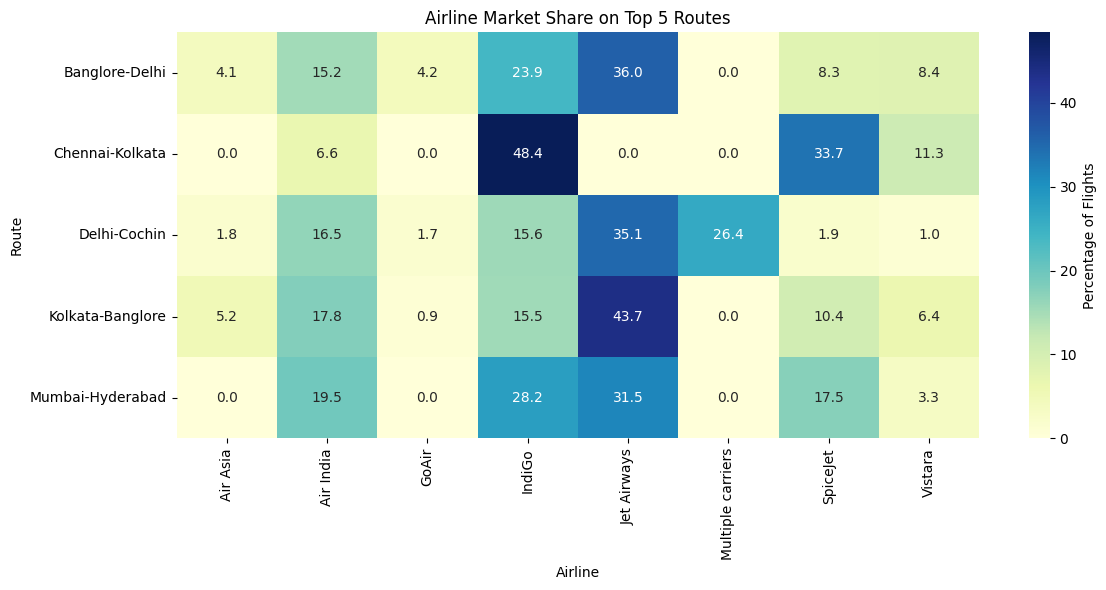

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
sns.heatmap(top_routes_airline_percentages, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage of Flights'})
plt.title('Airline Market Share on Top 5 Routes')
plt.xlabel('Airline')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate and print overall average price for each route
overall_avg = top_routes_data.groupby('Route')['Price'].mean().sort_values(ascending=False)
print("Overall average prices for top 5 routes (INR):")
print(overall_avg)

Overall average prices for top 5 routes (INR):
Route
CCU ? BOM ? BLR    137.917997
DEL ? BOM ? COK    123.468440
BLR ? DEL           71.864887
CCU ? BLR           55.013585
BOM ? HYD           49.338009
Name: Price, dtype: float64


In [ ]:
# Calculate and print price range (min to max) for each route
price_range = top_routes_data.groupby('Route').agg({'Price': ['min', 'max']})
print("\nPrice ranges for top 5 routes (INR):")
print(price_range)


Price ranges for top 5 routes (INR):
                      Price            
                        min         max
Route                                  
BLR ? DEL         55.404255  220.000000
BOM ? HYD         37.800000  152.076923
CCU ? BLR         48.086957   91.333333
CCU ? BOM ? BLR  116.592593  145.920792
DEL ? BOM ? COK   60.700000  337.833333


In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Duration_Minutes,number_of_stops,non_stop,distance_miles,departure_period,airline_type,airline_hub,full_route,price_per_mile,price_per_minute
0,IndiGo,2019-03-24,Banglore,Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,170,0,1,1560,evening,low cost,Delhi,Banglore-Delhi,0.030128,0.276471
1,Air India,2019-05-01,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,...,445,2,0,1560,morning,full service,Delhi,Kolkata-Banglore,0.058974,0.206742
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,1140,2,0,1740,morning,full service,Mumbai,Delhi-Cochin,0.095977,0.146491
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,...,325,1,0,1560,evening,low cost,Delhi,Kolkata-Banglore,0.048077,0.230769
4,IndiGo,2019-03-01,Banglore,Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,...,285,1,0,1560,afternoon,low cost,Delhi,Banglore-Delhi,0.102564,0.561404


### Plot Average Price by Month

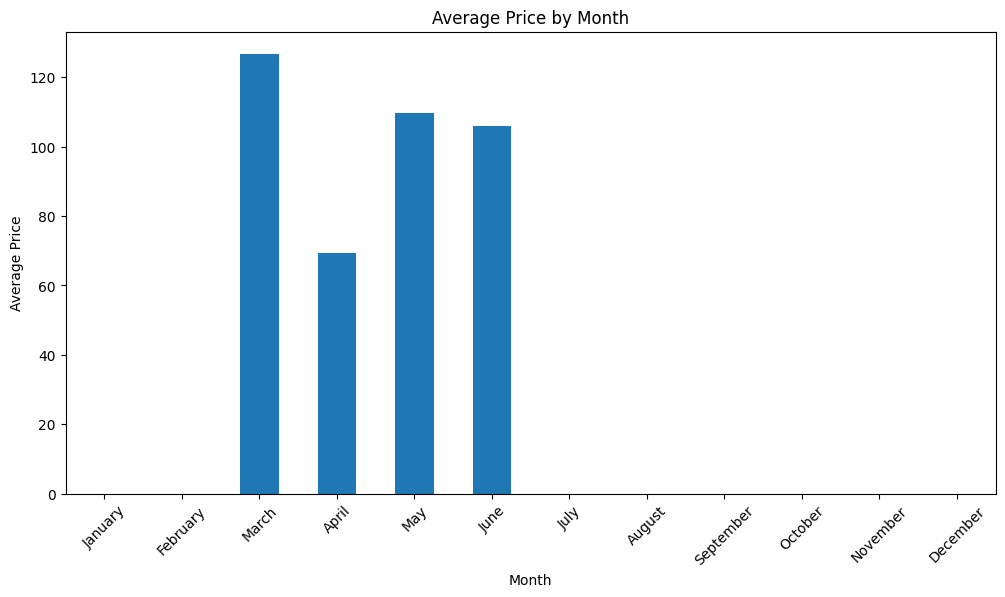

In [ ]:
# Convert 'Date_of_Journey' to datetime
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

# Extract month and day of week from the date
df['Month'] = df['Date_of_Journey'].dt.month_name()

# Analyze price trends by month
monthly_avg = df.groupby('Month')['Price'].mean().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

##### Price Trends Over Time

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Train.csv')
import pandas as pd
from prettytable import PrettyTable
#Identify unique values
airline = df['Airline']
uq_airlines = airline.unique()
routes = df['Route']
uq_routes = routes.unique()

#Create a PrettyTable
table = PrettyTable()
table.field_names = ["Route", "Airline", "Mean Price"]

#Iterate through each route and airline to calculate the mean price
for route in uq_routes:
    for airline in uq_airlines:
        mean_price = df[(df['Route'] == route) & (df['Airline'] == airline)]['Price'].mean()

        if not pd.isna(mean_price):
            table.add_row([route, airline, f"{mean_price:.2f}"])
print(table)


+-----------------------------------+-----------------------------------+------------+
|               Route               |              Airline              | Mean Price |
+-----------------------------------+-----------------------------------+------------+
|             BLR ? DEL             |               IndiGo              |  5059.04   |
|             BLR ? DEL             |             Air India             |  6722.29   |
|             BLR ? DEL             |            Jet Airways            |  6500.71   |
|             BLR ? DEL             |              SpiceJet             |  4302.20   |
|             BLR ? DEL             |               GoAir               |  4767.03   |
|             BLR ? DEL             |              Vistara              |  5957.51   |
|             BLR ? DEL             |              Air Asia             |  4574.28   |
|             BLR ? DEL             |      Vistara Premium economy      |  8881.00   |
|       CCU ? IXR ? BBI ? BLR       |      

### Route and Airline Comparison (Price & Qty)

In [ ]:
# Routes
route_price_cnt = df.groupby(['full_route'])['Price'].agg(['count','mean'])
route_price_cnt.rename(columns={'count': 'total_flights', 'mean': 'average_price'}, inplace=True)

# Airlines
airline_price_cnt = df.groupby(['Airline'])['Price'].agg(['count','mean'])
airline_price_cnt.rename(columns={'count': 'total_flights', 'mean': 'average_price'}, inplace=True)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
route_price_cnt.plot(kind='bar',ax=ax[0])
airline_price_cnt.plot(kind='bar',ax=ax[1])

ax[0].set_title('Flight Count and Average Price by Route')
ax[1].set_title('Flight Count and Average Price by Airline')

KeyError: 'full_route'

### Route and Airline Comparison (Attributes)


In [ ]:
# Route - Stops
agg_route_stops = df.groupby(['full_route','non_stop'])['Price'].agg(['count','mean']).reset_index()
stops_pivot_df = agg_route_stops.pivot(index='full_route', columns='non_stop', values='count').fillna(0)
stops_percentage_df = stops_pivot_df.div(stops_pivot_df.sum(axis=1), axis=0) * 100

# Route - Airline Type
agg_route_airline = df.groupby(['full_route','airline_type'])['Price'].agg(['count','mean']).reset_index()
airline_pivot_df = agg_route_airline.pivot(index='full_route', columns='airline_type', values='count').fillna(0)
airline_percentage_df = airline_pivot_df.div(airline_pivot_df.sum(axis=1), axis=0) * 100

# Route - Departure Period
agg_route_period = df.groupby(['full_route','departure_period'])['Price'].agg(['count','mean']).reset_index()
period_pivot_df = agg_route_period.pivot(index='full_route', columns='departure_period', values='count').fillna(0)
period_percentage_df = period_pivot_df.div(period_pivot_df.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 7))
stops_percentage_df.plot(kind='barh', stacked=True, ax=ax[0])
airline_percentage_df.plot(kind='barh', stacked=True, ax=ax[1])
period_percentage_df.plot(kind='barh', stacked=True, ax=ax[2])

ax[0].set_title('% Breakdown by Stops')
ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0), title='Non-Stop')

ax[1].set_title('% Breakdown by Airline Type')
ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0), title='Type')

ax[2].set_title('% Breakdown by Departure Period')
ax[2].legend(loc='lower right', bbox_to_anchor=(1, 0), title='Period')

In [ ]:
# Airline - Stops
agg_airline_stops = df.groupby(['Airline','non_stop'])['Price'].agg(['count','mean']).reset_index()
stops_pivot_df = agg_airline_stops.pivot(index='Airline', columns='non_stop', values='count').fillna(0)
stops_percentage_df = stops_pivot_df.div(stops_pivot_df.sum(axis=1), axis=0) * 100

# Airline - Departure Period
agg_airline_period = df.groupby(['Airline','departure_period'])['Price'].agg(['count','mean']).reset_index()
period_pivot_df = agg_airline_period.pivot(index='Airline', columns='departure_period', values='count').fillna(0)
period_percentage_df = period_pivot_df.div(period_pivot_df.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 7))
stops_percentage_df.plot(kind='barh', stacked=True, ax=ax[0])
period_percentage_df.plot(kind='barh', stacked=True, ax=ax[1])

ax[0].set_title('% Breakdown by Stops')
ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0), title='Non-Stop')

ax[1].set_title('% Breakdown by Departure Period')
ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0), title='Period')

#### Best Value by Consumer Type (Weighted Scoring Model)




In [ ]:
# Filter to 'Dehi-Cochin route'
Delhi_Cochin = df[df['full_route'] == 'Delhi-Cochin'].reset_index(drop=True)
departure_mapping = {'morning': 2, 'afternoon': 0, 'evening': 0}
Delhi_Cochin['departure_score'] = Delhi_Cochin['departure_period'].map(departure_mapping)

type_mapping = {'low cost': 0, 'full service': 1}
Delhi_Cochin['airline_type_score'] = Delhi_Cochin['airline_type'].map(type_mapping)

# Delhi_Cochin['non_stop'] = Delhi_Cochin['number_of_stops'].apply(lambda x: 1 if x == 0 else 0)

# Normalize values
scaler = MinMaxScaler()
Delhi_Cochin[['normalized_duration', 'normalized_price']] = scaler.fit_transform(
    Delhi_Cochin[['Duration_Minutes', 'Price']])

# Weights for a business traveler
weight_duration = .3
weight_stops = .3
weight_type = .1
weight_price = .2
weight_departure = .1

# Calculate business value score
Delhi_Cochin['business_value_score'] = (
    (1 - Delhi_Cochin['normalized_duration']) * weight_duration +
    (1 - Delhi_Cochin['normalized_price']) * weight_price +
    Delhi_Cochin['departure_score'] * weight_departure +
    Delhi_Cochin['airline_type_score'] * weight_type +
    Delhi_Cochin['non_stop'] * weight_stops
)

# Weights for a leasure traveler
weight_leasure_duration = .2
weight_leasure_stops = .1
weight_leasure_type = 0
weight_leasure_price = .7
weight_leasure_departure = 0

# Calculate leisure value score
Delhi_Cochin['leisure_value_score'] = (
    (1 - Delhi_Cochin['normalized_duration']) * weight_leasure_duration +
    (1 - Delhi_Cochin['normalized_price']) * weight_leasure_price +
    Delhi_Cochin['departure_score'] * weight_leasure_departure +
    Delhi_Cochin['airline_type_score'] * weight_leasure_type +
    Delhi_Cochin['non_stop'] * weight_leasure_stops
)

route_value = Delhi_Cochin.groupby(['full_route','Route','Airline'])[['business_value_score','leisure_value_score','non_stop','Price','Duration_Minutes','airline_type_score','departure_score']].mean().reset_index().sort_values(by=['full_route', 'leasure_value_score'], ascending=False)

In [ ]:
# unpivot for heatamp
business = route_value.pivot(index='Route', columns='Airline', values='business_value_score')
leisure = route_value.pivot(index='Route', columns='Airline', values='leasure_value_score')

# plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
sns.heatmap(business, annot=True, cmap="Reds", alpha = .8, cbar=False, ax=ax[0])
sns.heatmap(leisure, annot=True, cmap="Blues", alpha = .8, cbar=False, ax=ax[1])
# I want the third graph to be the columns for price, number of stops, etc.

ax[0].set_title("Business Value Score Heatmap")
ax[1].set_title("Leisure Value Score Heatmap")

### Kernel Density Plot of Price Distribution

In [ ]:
#KDE plots shwoing density distribution of prices for different airlines
sns.displot(data=df, x='Price', col='Airline', col_wrap=4, kind='kde')

###Cheapest Attributes

In [ ]:
#Cheapest attributes
# Find the minimum price
min_price = df['Price'].min()

df['Day_of_Flight'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

# Retrieve the row(s) with the minimum price
cheapest_flight = df[df['Price'] == min_price].iloc[0]  # Use iloc[0] if there are multiple rows with the same min price

# Extract details
cheapest_time = cheapest_flight['Dep_Time']
cheapest_airline = cheapest_flight['Airline']  # Replace 'Airline' with the actual column name for airline
cheapest_duration = cheapest_flight['Duration']
cheapest_stops = cheapest_flight['Total_Stops']  # Replace 'Number_of_Stops' with the actual column name for number of stops
cheapest_day = cheapest_flight['Day_of_Flight']  # Replace 'Day_of_Flight' with the actual column name for the day

# Print the results
print(f"Cheapest Time: {cheapest_time}")
print(f"Cheapest Airline: {cheapest_airline}")
print(f"Cheapest Duration: {cheapest_duration}")
print(f"Cheapest Number of Stops: {cheapest_stops}")
print(f"Cheapest Day to Fly: {cheapest_day}")

###Bar Plot of Price by Time period


In [ ]:
df['departure_period'] = df['Dep_Time'].apply(get_period)
avg_prices = df.groupby('departure_period')['Price'].mean().reset_index()
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_prices, x='departure_period', y='Price', palette='viridis')

# Add labels and title
plt.xlabel('Time Period')
plt.ylabel('Average Price (USD)')
plt.title('Average Flight Price by Time Period')

# Show the plot
plt.show()


NameError: name 'df' is not defined

###Line Plot of Price vs Number of Stops

In [ ]:

conversion_rate = 70.4059

#Convert the Price column from INR to USD
df['Price_USD'] = df['Price'] / conversion_rate

#Mapping for stops to int values
stop_mapping = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}

#Number of stops to int type
df['Number_of_Stops_Int'] = df['Total_Stops'].map(stop_mapping)

#Group by 'Airline' and 'Number_of_Stops_Int' and calculate the average price
average_prices_by_stops_airline = df.groupby(['Airline', 'Number_of_Stops_Int'])['Price_USD'].mean().reset_index()
average_prices_by_stops_airline.columns = ['Airline', 'Number of Stops', 'Average Price (INR)']

#Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=average_prices_by_stops_airline, x='Number of Stops', y='Average Price (INR)', hue='Airline', marker='o')

plt.xlabel('Number of Stops')
plt.ylabel('Average Price (USD)')
plt.title('Average Flight Price by Number of Stops and Airline')
plt.legend(title='Airline')

#Set x-axis to show only integer values
plt.xticks(ticks=range(0, 5))

plt.tight_layout()
plt.show()

###Barplot Of Airline Carriers by Price

In [ ]:
#Average Price of Each Airline
conversion_rate = 70.4059
df['Price'] = df['Price'] / conversion_rate
#Group by airline and calculate average costs
average_prices = df.groupby('Airline')['Price_USD'].mean().reset_index()

#Rename columns
average_prices.columns = ['Airline', 'Average Price']

#Plotting definitions
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=average_prices, x='Airline', y='Average Price', palette='viridis')

#Axis and main titles
plt.xlabel('Airline')
plt.ylabel('Average Price (USD)')
plt.title('Average Flight Price by Airline')
plt.xticks(rotation=45)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 5),
                     textcoords = 'offset points')
plt.tight_layout()
plt.show()

###Minimum Price Attributes

In [ ]:
#Minimum price
min_price = df['Price'].min()

df['Day_of_Flight'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

#Retrieve rows with the minimum price
cheapest_flight = df[df['Price'] == min_price].iloc[0]

#Extract details
cheapest_time = cheapest_flight['Dep_Time']
cheapest_airline = cheapest_flight['Airline']
cheapest_duration = cheapest_flight['Duration']
cheapest_stops = cheapest_flight['Total_Stops']
cheapest_day = cheapest_flight['Day_of_Flight']

#Results Output
print(f"Cheapest Time: {cheapest_time}")
print(f"Cheapest Airline: {cheapest_airline}")
print(f"Cheapest Duration: {cheapest_duration}")
print(f"Cheapest Number of Stops: {cheapest_stops}")
print(f"Cheapest Day to Fly: {cheapest_day}")

###Duration vs. Price Barplot

In [ ]:
#Function to convert duration string to total minutes
def duration_to_minutes(duration_str):
    hours = 0
    minutes = 0
    if 'h' in duration_str:
        hours = int(re.search(r'(\d+)h', duration_str).group(1))
    if 'm' in duration_str:
        minutes = int(re.search(r'(\d+)m', duration_str).group(1))
    return hours * 60 + minutes

#Apply the conversion function to the Duration column
df['Duration_Mins'] = df['Duration'].apply(duration_to_minutes)

#Calculate overall average price for each duration
average_price_by_duration = df.groupby('Duration_Mins')['Price_USD'].mean().reset_index()
average_price_by_duration.columns = ['Duration (mins)', 'Average Price (USD)']

#Plotting
plt.figure(figsize=(12, 8))

#Create bar plot
barplot = sns.barplot(data=average_price_by_duration, x='Duration (mins)', y='Average Price (USD)', palette='viridis', ci=None)
#Set x axis frequency
plt.xticks(ticks=plt.xticks()[0][::20])
#Labels
plt.xlabel('Duration (mins)')
plt.ylabel('Average Price (USD)')
plt.title('Overall Average Price vs Duration')
plt.tight_layout()
plt.show()


###Departure time vs. Price Line Plot

In [ ]:
#Create a new column to represent the departure time as a numeric value for plotting
df['Departure_Time_Num'] = [datetime.combine(datetime.today(), t).timestamp() for t in df['Dep_Time']]
#Sort the DataFrame by the numeric representation of departure time
df_sorted = df.sort_values('Departure_Time_Num')


plt.figure(figsize=(12, 8))

#Line plot of Price vs Departure Time
sns.lineplot(data=df_sorted, x='Departure_Time_Num', y='Price_USD', marker='o', linestyle='-', color='b')

#Plotting
plt.xlabel('Departure Time')
plt.ylabel('Price (USD)')
plt.title('Price vs Departure Time')

#Format x-axis ticks to show time in HH:MM format
plt.xticks(
    ticks=[datetime.fromtimestamp(ts).timestamp() for ts in range(int(df_sorted['Departure_Time_Num'].min()), int(df_sorted['Departure_Time_Num'].max()), 3600)],
    labels=[datetime.fromtimestamp(ts).strftime('%H:%M') for ts in range(int(df_sorted['Departure_Time_Num'].min()), int(df_sorted['Departure_Time_Num'].max()), 3600)],
    rotation=45
)

plt.tight_layout()
plt.show()

###India Heat Map

In [ ]:
#Source heatmap
df2 = df
city_coordinates = {
    'Cochin': (9.9312, 76.2673),
    'New Delhi': (28.7041, 77.1025),
    'Delhi': (28.7041, 77.1025),
    'Banglore': (12.9716, 77.5946),
    'Kolkata' : (22.5744, 88.3629),
    'Chennai' : (13.0843, 80.2705),
    'Hyderabad' : (17.4065, 78.4772),
}
df2['Latitude'] = df2['Source'].apply(lambda x: city_coordinates.get(x,(None,None))[0])
df2['Longitude'] = df2['Source'].apply(lambda x: city_coordinates.get(x,(None,None))[1])

df2 = df2.dropna(subset = ['Latitude','Longitude',])


#Prepare the data for the heatmap
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df.iterrows()]

#Initialize the map centered around India
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

#Add the heat map layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

#Save the map to an HTML file
m.save("india_flights_heatmap_des.html")

In [ ]:
#Destination heatmap
df2 = df
city_coordinates = {
    'Cochin': (9.9312, 76.2673),
    'New Delhi': (28.7041, 77.1025),
    'Delhi': (28.7041, 77.1025),
    'Banglore': (12.9716, 77.5946),
    'Kolkata' : (22.5744, 88.3629),
    'Chennai' : (13.0843, 80.2705),
    'Hyderabad' : (17.4065, 78.4772),
}
df2['Latitude'] = df2['Destination'].apply(lambda x: city_coordinates.get(x,(None,None))[0])
df2['Longitude'] = df2['Destination'].apply(lambda x: city_coordinates.get(x,(None,None))[1])

df2 = df2.dropna(subset = ['Latitude','Longitude',])


#Prepare the data for the heatmap
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df.iterrows()]

#Initialize the map centered around India
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

#Add the heat map layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

#Save the map to an HTML file
m.save("india_flights_heatmap_des.html")